# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options)

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=100)

In [2]:
# X - features, y - labels
len(X), len(y)

(1000, 1000)

In [3]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[-1.00038985  0.02348052]
 [-0.19036705 -1.01750748]
 [ 0.71463597  0.37954286]
 [ 0.60316858 -0.78886949]
 [ 0.56238969  0.56515025]]
First 5 samples of y:
 [0 0 1 0 1]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "Label": y})
circles.head(10)

,X1,X2,Label
0,-1.000390,0.023481,0
1,-0.190367,-1.017507,0
2,0.714636,0.379543,1
3,0.603169,-0.788869,0
4,0.562390,0.565150,1
5,0.025748,1.006406,0
6,1.050432,-0.097989,0
7,0.623187,0.525558,1
8,0.747905,-0.180497,1
9,0.559672,-0.620578,1


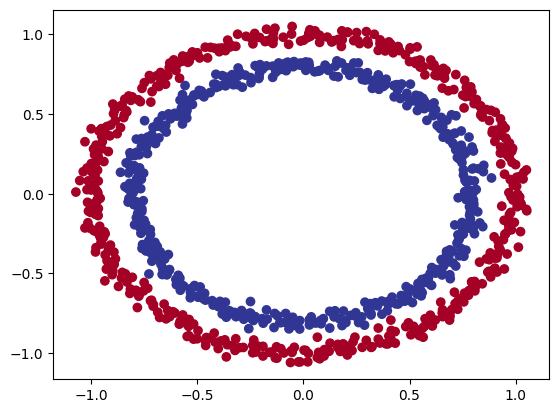

In [5]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to sa a toy dataset, a dataset that is smaal enough to experiment but stull sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [6]:
print(f'Shape of X:\n {X.shape}')
print(f'Shape of y:\n {y.shape}')
print(f'X is:\n {X}')

Shape of X:
 (1000, 2)
Shape of y:
 (1000,)
X is:
 [[-1.00038985  0.02348052]
 [-0.19036705 -1.01750748]
 [ 0.71463597  0.37954286]
 ...
 [-0.34854069 -0.73386791]
 [-0.69073184 -0.39968317]
 [ 0.74728993  0.23031586]]


In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-1.00038985  0.02348052] and the same for y: 0
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors
import torch
torch.__version__

'1.12.1+cu116'

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-1.0004,  0.0235],
         [-0.1904, -1.0175],
         [ 0.7146,  0.3795],
         [ 0.6032, -0.7889],
         [ 0.5624,  0.5652]]),
 tensor([0., 0., 1., 0., 1.]))

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data will be test
                                                    random_state=100)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building model

Let's build a model to classify our blue and red dots.

We want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construc a model (by subclassing `nn.Moduel`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [12]:
import torch
from torch import nn

# Make device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setup device agnostic code
1. Subclasses `nn.Module` 
2. Create 2 `nn.Linear()` Layers
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instatiate an instance of our model class and send it to the target device

In [13]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.linear_layer1 = nn.Linear(in_features=2,
                                       out_features=5)
        self.linear_layer2 = nn.Linear(in_features=5,
                                       out_features=1)
        
    # 3. Define forward method that outlines the forward pass
    def forward(self, x):
        return self.linear_layer2(self.linear_layer1(x)) # x -> Layer_1 -> Layer_2 -> output
    
# 4. Instantiate an instance of our model class and sned it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (linear_layer1): Linear(in_features=2, out_features=5, bias=True)
  (linear_layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Check if model is on target device
next(model_0.parameters()).device

device(type='cuda', index=0)

In [15]:
# Let's replicate the model using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2873, -0.5599],
                      [-0.0253, -0.4847],
                      [ 0.0891,  0.1264],
                      [-0.3032,  0.6372],
                      [ 0.0089, -0.5150]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6955,  0.3581,  0.2183, -0.1783, -0.3642], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0044,  0.3091, -0.2662,  0.4221,  0.1307]], device='cuda:0')),
             ('1.bias', tensor([-0.0023], device='cuda:0'))])

In [17]:
# Make predicitons

untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0423],
        [-0.1505],
        [-0.0657],
        [-0.0101],
        [ 0.0298],
        [-0.1925],
        [-0.1809],
        [-0.2193],
        [ 0.0712],
        [ 0.0213]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 1.])


### 2.1 Setup loss function and optimizer

Which loss fucntion or optimizer should you use ?

For example for regression you might want MAE or MSE.

For Classification you might want binary cross entropy or categorical cross entropy

As a reminder, the loss function measure how wrong our model predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

In [18]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Have sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [44]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train model

To traing model, we need training loop.
1. Forward pass
2. Calculate loss
3. Optimizer zero gradient
4. Loss backward (backpropagation loss)
5. Optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction lables

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`

In [20]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0423],
        [-0.1505],
        [-0.0657],
        [-0.0101],
        [ 0.0298]], device='cuda:0')

In [21]:
y_test[:5]

tensor([1., 1., 0., 1., 1.])

In [22]:
# Use the sigmoid activation function on our model logits to turn them into prediction pobabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4894],
        [0.4624],
        [0.4836],
        [0.4975],
        [0.5074]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [23]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 1., 0., 1., 1.])

### 3.2 Building a training and testing loop

In [25]:
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):

    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    #loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #               y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print info
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc:{acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69548 | Acc:47.75% | Test loss: 0.69305 | Test acc: 48.00%
Epoch: 10 | Loss: 0.69420 | Acc:49.50% | Test loss: 0.69465 | Test acc: 51.50%
Epoch: 20 | Loss: 0.69369 | Acc:50.12% | Test loss: 0.69600 | Test acc: 50.00%
Epoch: 30 | Loss: 0.69342 | Acc:51.25% | Test loss: 0.69705 | Test acc: 48.00%
Epoch: 40 | Loss: 0.69326 | Acc:51.88% | Test loss: 0.69784 | Test acc: 47.00%
Epoch: 50 | Loss: 0.69313 | Acc:52.00% | Test loss: 0.69846 | Test acc: 47.00%
Epoch: 60 | Loss: 0.69303 | Acc:52.50% | Test loss: 0.69895 | Test acc: 47.50%
Epoch: 70 | Loss: 0.69295 | Acc:52.50% | Test loss: 0.69935 | Test acc: 48.00%
Epoch: 80 | Loss: 0.69288 | Acc:52.75% | Test loss: 0.69968 | Test acc: 47.00%
Epoch: 90 | Loss: 0.69282 | Acc:52.75% | Test loss: 0.69996 | Test acc: 47.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual 

To do so, we're going to import a function called `plot_decision_boundary()`

In [54]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping dowload")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping dowload


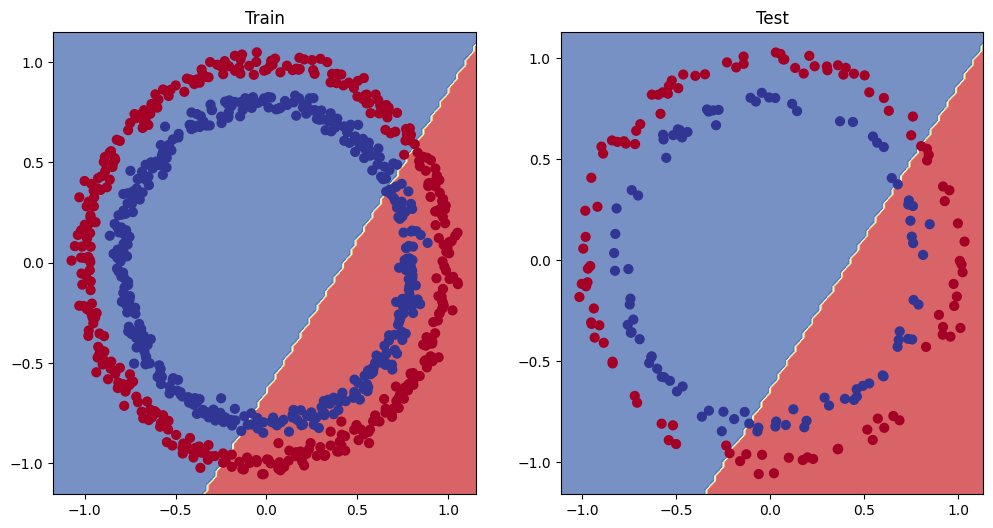

In [27]:
# Plot decision boundry of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train, device)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test, device)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer 
* Changing the activation functions 
* Change the larning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as ML engineers and data scientists) can change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [28]:
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        # OR you can do this 
        # return self.layer_3(self.layer_2(self.layer_1(x)))
        return z
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [30]:
# Write a training and evaluation loop for model_1
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Traing for longer 
epochs = 1000

# Put data on the target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ###Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        

    # Print epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.73060 | Acc: 48.88% | Test loss: 0.70583 | Test acc: 54.50%
Epoch: 100 | Loss: 0.69221 | Acc: 54.00% | Test loss: 0.70058 | Test acc: 43.00%
Epoch: 200 | Loss: 0.69218 | Acc: 54.00% | Test loss: 0.70168 | Test acc: 42.00%
Epoch: 300 | Loss: 0.69218 | Acc: 53.87% | Test loss: 0.70198 | Test acc: 42.00%
Epoch: 400 | Loss: 0.69218 | Acc: 54.00% | Test loss: 0.70207 | Test acc: 42.00%
Epoch: 500 | Loss: 0.69218 | Acc: 54.12% | Test loss: 0.70210 | Test acc: 42.00%
Epoch: 600 | Loss: 0.69218 | Acc: 54.00% | Test loss: 0.70211 | Test acc: 42.00%
Epoch: 700 | Loss: 0.69218 | Acc: 54.00% | Test loss: 0.70212 | Test acc: 42.00%
Epoch: 800 | Loss: 0.69218 | Acc: 54.00% | Test loss: 0.70212 | Test acc: 42.00%
Epoch: 900 | Loss: 0.69218 | Acc: 54.00% | Test loss: 0.70212 | Test acc: 42.00%


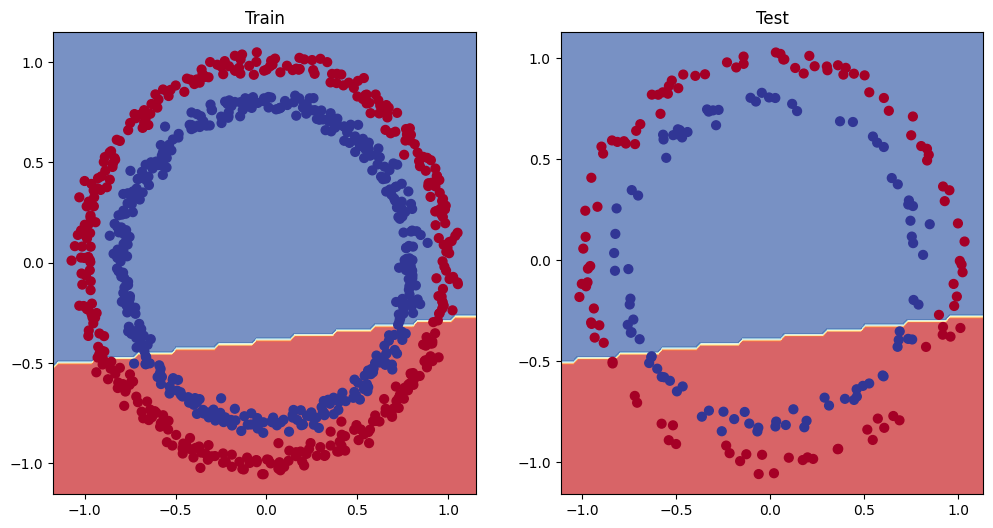

In [31]:
# Plot the decision boundry
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train, device)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test, device)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a large problem is to test out a smaller problem


In [32]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data 
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [33]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lenghts of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

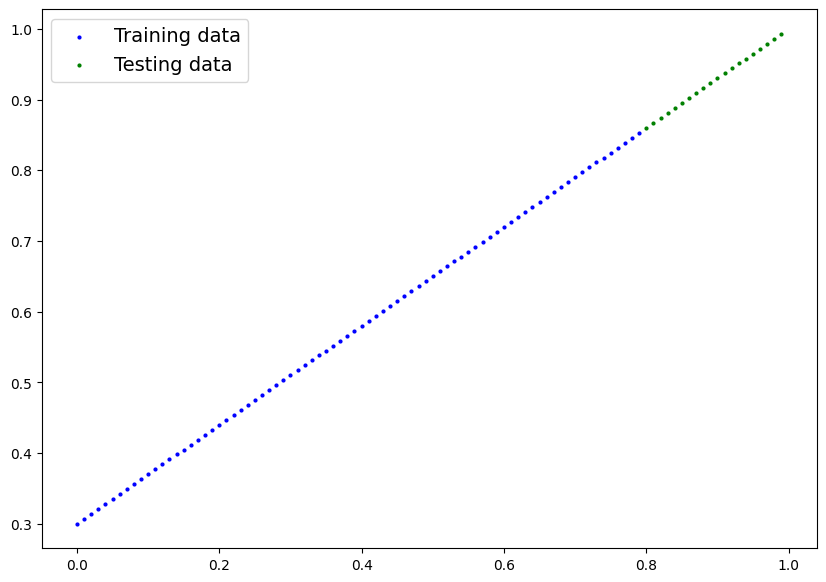

In [35]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

### 5.2 Adjust `model_1` to fit a straight line


In [45]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [52]:
# Train the model
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, X_test_regression = X_train_regression.to(device), X_test_regression.to(device)
y_train_regression, y_test_regression = y_train_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    # Print epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.00977 | Test loss: 0.03158
Epoch: 100 | Loss: 0.00978 | Test loss: 0.03203
Epoch: 200 | Loss: 0.00966 | Test loss: 0.03189
Epoch: 300 | Loss: 0.00987 | Test loss: 0.03204
Epoch: 400 | Loss: 0.00994 | Test loss: 0.03160
Epoch: 500 | Loss: 0.00937 | Test loss: 0.03104
Epoch: 600 | Loss: 0.00962 | Test loss: 0.03137
Epoch: 700 | Loss: 0.00925 | Test loss: 0.03051
Epoch: 800 | Loss: 0.00922 | Test loss: 0.03096
Epoch: 900 | Loss: 0.00928 | Test loss: 0.03104


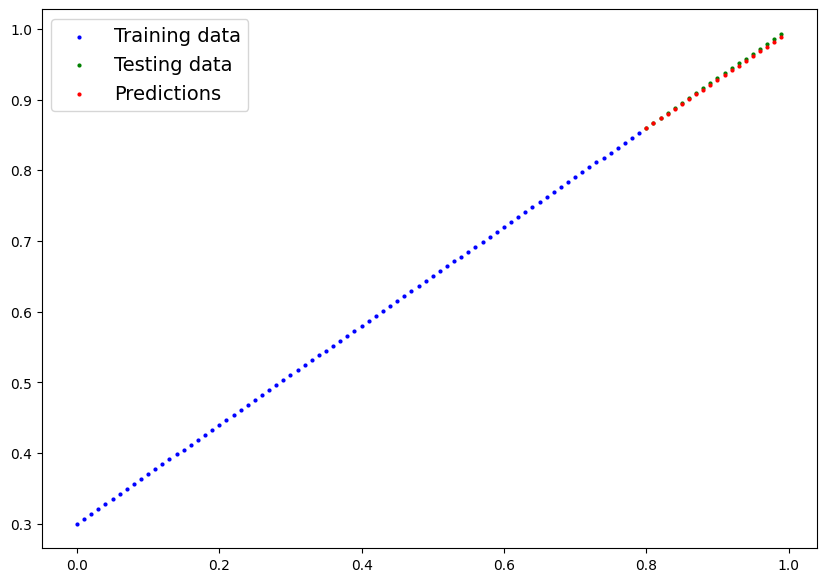

In [56]:
# Turn on evalutaion
model_2.eval()

# Make predictions(inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())


## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?"

Or in ML terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

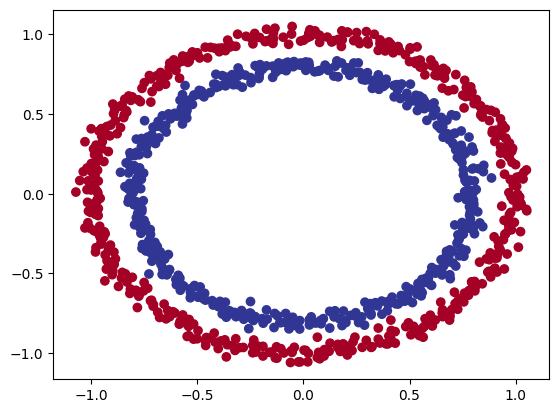

In [65]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=100)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [66]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

X_train[:5], y_train[:5]


(tensor([[ 1.0185,  0.1074],
         [ 0.1258, -0.9372],
         [ 0.0194,  0.9787],
         [ 0.7262, -0.6754],
         [-0.9791,  0.1902]]),
 tensor([0., 0., 0., 0., 0.]))

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = non straight line

In [67]:
# Build a model with non-linear activation functions
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Non-linear activation function

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.relu(x)
        x = self.layer_3(x)
        # return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) I don't like this one
        return x
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [68]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)


### 6.3 Training a model with non-linearity

In [75]:
torch.manual_seed(100)
torch.cuda.manual_seed(100)

# Put all data on target evice
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()
    

    ### TESTING
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.0303, Acc: 100.00% | Test loss: 0.0385, Test Acc: 99.00%
Epoch: 100 | Loss: 0.0268, Acc: 100.00% | Test loss: 0.0352, Test Acc: 99.00%
Epoch: 200 | Loss: 0.0240, Acc: 100.00% | Test loss: 0.0327, Test Acc: 99.00%
Epoch: 300 | Loss: 0.0217, Acc: 100.00% | Test loss: 0.0308, Test Acc: 99.00%
Epoch: 400 | Loss: 0.0198, Acc: 100.00% | Test loss: 0.0292, Test Acc: 99.00%
Epoch: 500 | Loss: 0.0183, Acc: 100.00% | Test loss: 0.0280, Test Acc: 99.00%
Epoch: 600 | Loss: 0.0169, Acc: 100.00% | Test loss: 0.0269, Test Acc: 99.00%
Epoch: 700 | Loss: 0.0158, Acc: 100.00% | Test loss: 0.0260, Test Acc: 99.00%
Epoch: 800 | Loss: 0.0148, Acc: 100.00% | Test loss: 0.0252, Test Acc: 99.00%
Epoch: 900 | Loss: 0.0139, Acc: 100.00% | Test loss: 0.0245, Test Acc: 99.00%


### 6.4 Evaluating model trained with non-linear activation functions

In [76]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0'),
 tensor([1., 1., 0., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0'))

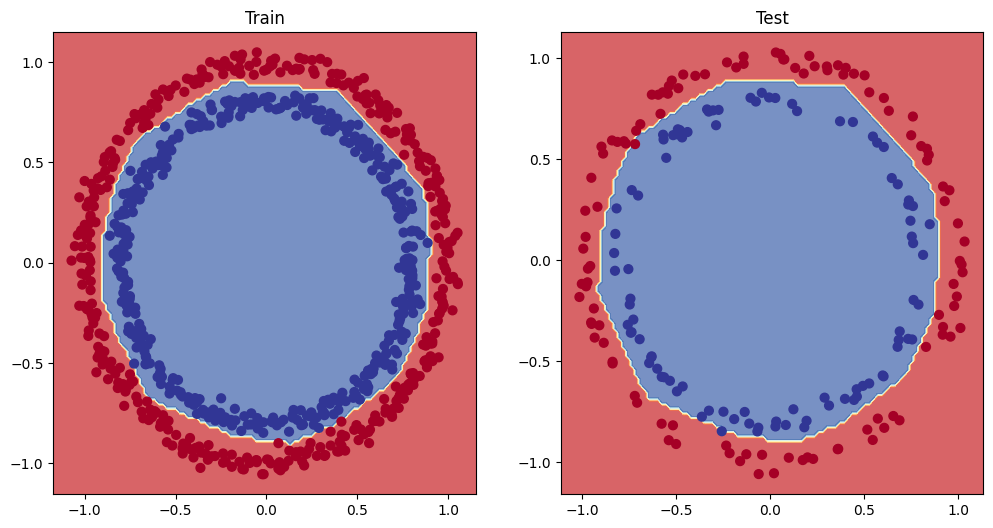

In [77]:
# Plot results 
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train, device)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test, device)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions

In [82]:
# Create a tensor
A = torch.arange(-10., 10., 1.)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

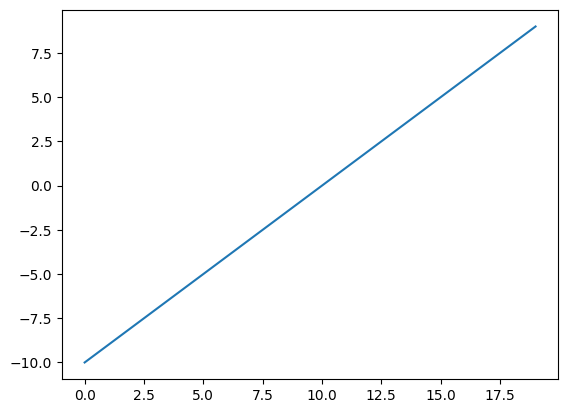

In [84]:
# Visualize the tensor
plt.plot(A)

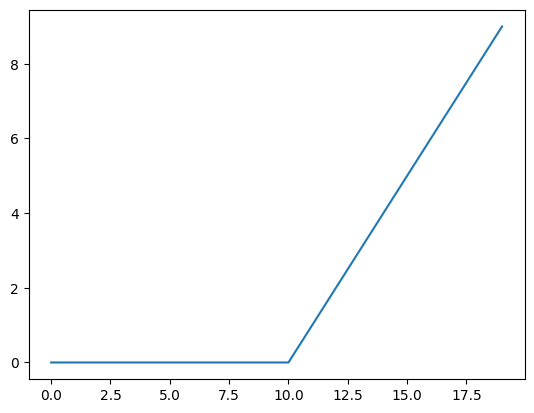

In [85]:
# PyTorch ReLU built-in
plt.plot(torch.relu(A))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])


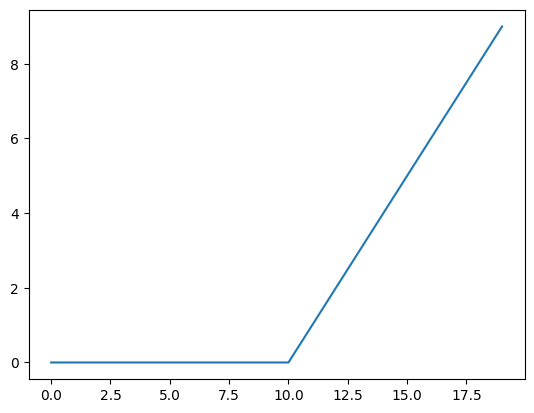

In [87]:
# ReLU our function
def relu(x:torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x) # inputs must be tensors

print(relu(A))
plt.plot(relu(A))

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])


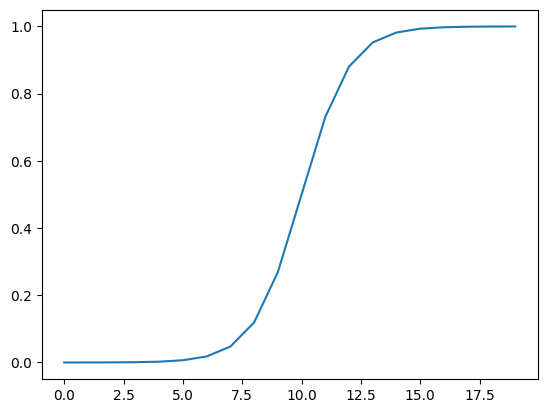

In [91]:
# Let's do own Sigmoid
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))
print(sigmoid(A))
plt.plot(sigmoid(A))

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])


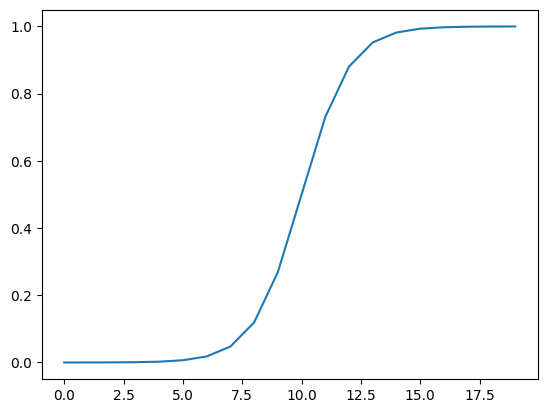

In [92]:
# Compare with PyTorch Sigmoid
print(torch.sigmoid(A))
plt.plot(torch.sigmoid(A))

## 8. Multi-class classification

* Binary classification = one thing or another (cat vs dog)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)


### 8.1 Creating a toy multi-class dataset

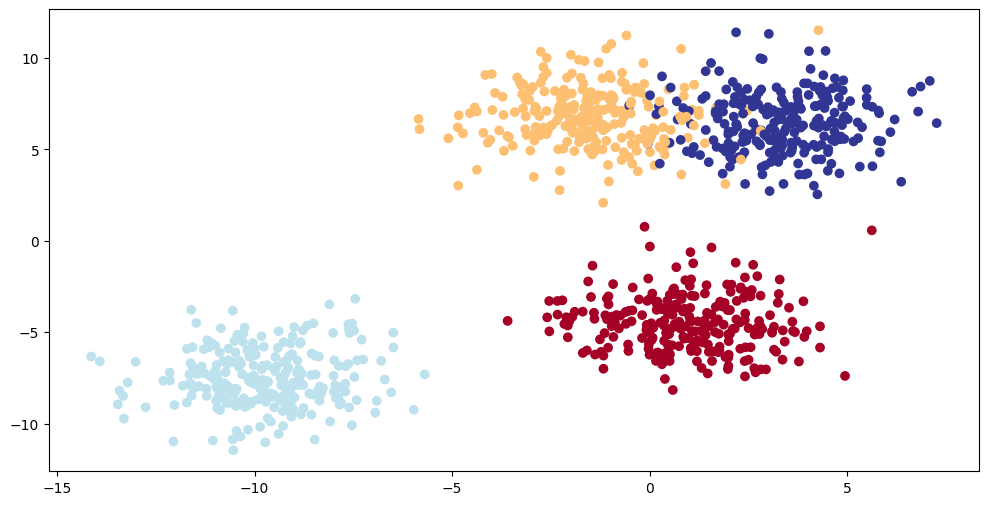

In [129]:
# Import dependecies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 100

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(12, 6))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [130]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [131]:
# Check how many features do we have
print(X_blob_train.shape, y_blob_train.shape)
# Check how many unique value do we have (it will be our number of classes)
print(torch.unique(y_blob_train))

torch.Size([800, 2]) torch.Size([800])
tensor([0, 1, 2, 3])


In [132]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        """Initializes multi-class classification model.

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int, optional): Number of hidden units beetwen units. Defaults to 8.
        """
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [133]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()
# Create a optimizer for a multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Building a train loop (Getting prediction probabilities for a multi-class PyTorch model)

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels

Logits (raw output of the model) -> Pred probs (use `torch.softmax`) -> Pred labels (take the `argmax` of the predictions probabilities)

In [134]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.2732,  0.4326, -0.1353, -0.2010],
        [ 0.1274,  1.3295,  0.9362,  0.3151],
        [ 0.2244,  2.1847,  1.4981, -0.5816],
        [-0.2881,  1.1559,  0.6309, -0.8802],
        [-0.2726,  0.4216, -0.1463, -0.2003],
        [ 0.0147,  1.8449,  1.1781, -0.7879],
        [-0.2722,  0.4268, -0.1431, -0.2019],
        [ 0.0729,  1.2158,  0.8909,  0.2569],
        [ 0.2349,  2.1007,  1.4226, -0.4817],
        [-0.3263,  0.2966, -0.1521, -0.1914]], device='cuda:0')

In [135]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.2732,  0.4326, -0.1353, -0.2010],
        [ 0.1274,  1.3295,  0.9362,  0.3151],
        [ 0.2244,  2.1847,  1.4981, -0.5816],
        [-0.2881,  1.1559,  0.6309, -0.8802],
        [-0.2726,  0.4216, -0.1463, -0.2003]], device='cuda:0')
tensor([[0.1905, 0.3859, 0.2187, 0.2048],
        [0.1286, 0.4277, 0.2886, 0.1551],
        [0.0825, 0.5858, 0.2948, 0.0368],
        [0.1205, 0.5107, 0.3021, 0.0667],
        [0.1919, 0.3842, 0.2177, 0.2063]], device='cuda:0')


In [136]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds, y_blob_test

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0,
         0, 2, 3, 0, 0, 2, 1, 2, 3, 0, 1, 1, 2, 0, 0, 1, 3, 1, 2, 3, 1, 2, 1, 3,
         3, 2, 3, 1, 3, 0, 2, 0, 2, 0, 1, 3, 3, 0, 0, 0, 1, 2, 2, 1, 3, 3, 0, 2,
         1, 0, 3, 0, 1, 2, 3, 1, 0, 1, 3, 2, 3, 0, 3, 2, 

### 8.5 Creating a training loop and testing loop for multi-class PyTorch model

In [137]:
# Fit the multi-class model to the data
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

# Loop through data 
for epoch in range(epochs):
    # Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)
    
    # Print epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.6305 | Acc: 25.12% | Test Loss: 1.3110 | Test acc: 52.00%
Epoch: 10 | Loss: 0.8726 | Acc: 49.50% | Test Loss: 0.8185 | Test acc: 52.00%
Epoch: 20 | Loss: 0.6125 | Acc: 82.25% | Test Loss: 0.5951 | Test acc: 83.50%
Epoch: 30 | Loss: 0.4039 | Acc: 95.62% | Test Loss: 0.4124 | Test acc: 94.00%
Epoch: 40 | Loss: 0.2755 | Acc: 97.00% | Test Loss: 0.2936 | Test acc: 95.50%
Epoch: 50 | Loss: 0.2009 | Acc: 97.25% | Test Loss: 0.2195 | Test acc: 95.50%
Epoch: 60 | Loss: 0.1589 | Acc: 97.12% | Test Loss: 0.1749 | Test acc: 95.50%
Epoch: 70 | Loss: 0.1354 | Acc: 97.12% | Test Loss: 0.1487 | Test acc: 95.50%
Epoch: 80 | Loss: 0.1212 | Acc: 97.00% | Test Loss: 0.1326 | Test acc: 95.50%
Epoch: 90 | Loss: 0.1123 | Acc: 97.00% | Test Loss: 0.1224 | Test acc: 95.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model



In [138]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  2.8229,  -2.8692,  -0.6413,  -2.2532],
        [  2.5070,   0.0835,  11.8692, -10.4509],
        [ -3.5942,  11.1468,   1.4914,   3.5582],
        [ -1.5019,   1.5184,  -3.1077,   4.2702],
        [  2.5825,  -2.5651,  -0.6882,  -1.9948],
        [ -2.8299,   7.1162,  -0.8095,   4.3040],
        [  2.6406,  -2.6362,  -0.6888,  -2.0456],
        [  1.4855,   1.7935,  10.7156,  -8.6560],
        [ -3.4180,  11.1383,   1.8660,   3.0699],
        [  1.0413,  -0.7907,  -0.6561,  -0.5718]], device='cuda:0')

In [139]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[9.6069e-01, 3.2399e-03, 3.0069e-02, 5.9988e-03],
        [8.5901e-05, 7.6119e-06, 9.9991e-01, 2.0251e-10],
        [3.9611e-07, 9.9943e-01, 6.4042e-05, 5.0590e-04],
        [2.9163e-03, 5.9773e-02, 5.8536e-04, 9.3673e-01],
        [9.4870e-01, 5.5152e-03, 3.6032e-02, 9.7551e-03],
        [4.5183e-05, 9.4297e-01, 3.4073e-04, 5.6647e-02],
        [9.5225e-01, 4.8650e-03, 3.4105e-02, 8.7814e-03],
        [9.8021e-05, 1.3339e-04, 9.9977e-01, 3.8630e-09],
        [4.7653e-07, 9.9959e-01, 9.3948e-05, 3.1315e-04],
        [6.4829e-01, 1.0379e-01, 1.1874e-01, 1.2918e-01]], device='cuda:0')

In [140]:
# Go from pred pobs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0], device='cuda:0'),
 tensor([0, 2, 1, 3, 0, 1, 0, 2, 1, 0], device='cuda:0'))

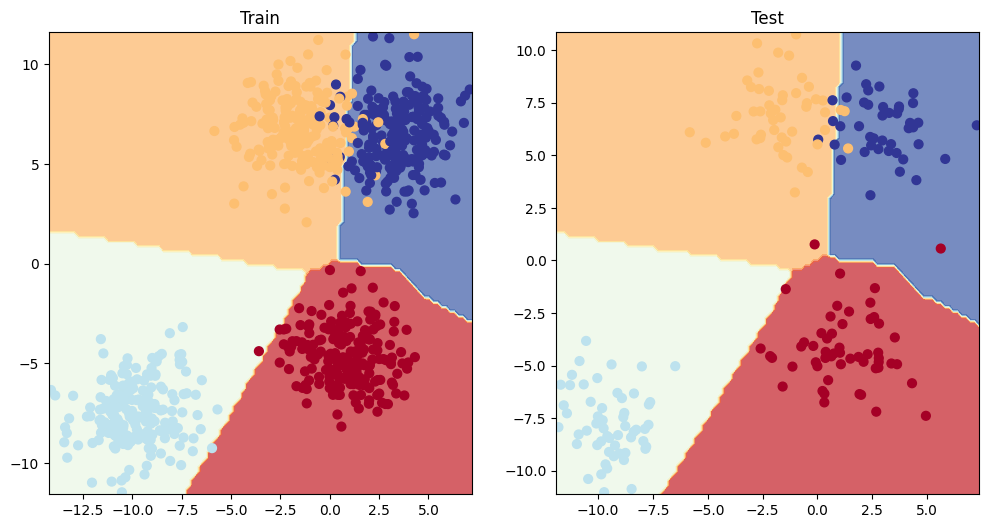

In [142]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train, device)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test, device)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy 
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report